# **Dataset loading and Preparation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
col = ['Text', 'Label', 'Code']
train = pd.read_csv("/content/drive/MyDrive/data/train.tsv", delimiter='\t', names=col)
test = pd.read_csv("/content/drive/MyDrive/data/dev.tsv", delimiter='\t', names=col)

In [ ]:
print ("Shape of the test data: ", test.shape)
test.info()

Shape of the test data:  (5426, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    5426 non-null   object
 1   Label   5426 non-null   object
 2   Code    5426 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


<Axes: ylabel='Frequency'>

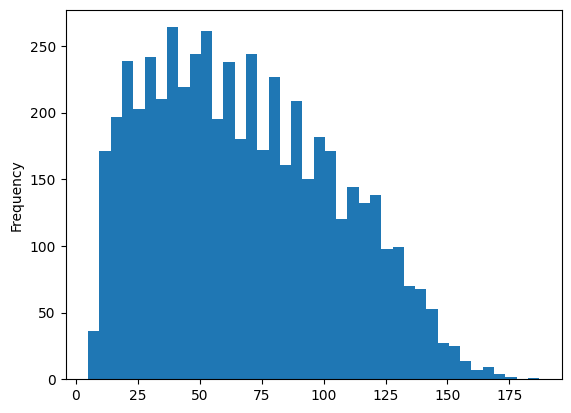

In [ ]:
test['Text'].str.len().plot.hist(bins = 40)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


def data_prep(df):
  df = df.dropna()
  df = df.reset_index(drop=True)

  df['Label'] = df['Label'].apply(lambda x: x.split(','))                            # Split the labels into a list
  multilabel = MultiLabelBinarizer()

  labels = multilabel.fit_transform(df['Label']).astype('float32')

  texts = df['Text'].tolist()

  return texts, labels



In [ ]:
x_train, y_train = data_prep(train)
x_test, y_test = data_prep(test)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# **Model Loading**

In [ ]:
!pip install -U transformers
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
#custom Dataset
class CustomDataset():
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [ ]:
train_dataset = CustomDataset(x_train, y_train, tokenizer)
val_dataset = CustomDataset(x_val, y_val, tokenizer)
test_dataset = CustomDataset(x_test, y_test, tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=28, problem_type="multi_label_classification")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):     #threshold can be tuned upto 0.5 for results, Predictions are logits (raw value from Model), need to apply signoid in it
  sigmoid = torch.nn.Sigmoid()                                    #using sigmoid from tourch
  probs = sigmoid(torch.Tensor(predictions))                      #applying sigmoid on predictions or logits

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1                          #for making the output in form of [0,0,0,1,0,0,1,....so on] to compare
  y_true = labels                                                 #actual labels

  f1 = f1_score(y_true, y_pred, average = 'macro')                #f1 score calculation
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')      #region of conversion score
  hamming = hamming_loss(y_true, y_pred)                          #lesser the hamming loss better is the output

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics





def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions                   #checks if the prediction is a tuple

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [ ]:
from transformers import TrainingArguments


args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=1,
    save_steps=1000,
    save_total_limit=2
)





In [ ]:
from transformers import Trainer


trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
500,0.135700
1000,0.116200
1500,0.106700
2000,0.101700
2500,0.098200
3000,0.097800
3500,0.095200
4000,0.089800
4500,0.090900
5000,0.090700


TrainOutput(global_step=5427, training_loss=0.10115785319347814, metrics={'train_runtime': 1091.3551, 'train_samples_per_second': 39.776, 'train_steps_per_second': 4.973, 'total_flos': 2856079305861120.0, 'train_loss': 0.10115785319347814, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.08748657256364822,
 'eval_roc_auc': 0.5,
 'eval_hamming_loss': 0.9580854088778895,
 'eval_f1': 0.07556047015157044,
 'eval_runtime': 18.6863,
 'eval_samples_per_second': 145.187,
 'eval_steps_per_second': 18.195,
 'epoch': 1.0}

In [ ]:
trainer.save_model("BERT_Finetuner_GoEmotion_Dataset")

In [ ]:
!zip -r Bert_finetune.zip "path of file to download model"

In [ ]:
predict = trainer.predict(test_dataset)

In [ ]:
compute_metrics(predict)

{'roc_auc': 0.5, 'hamming_loss': 0.957927439313359, 'f1': 0.07549884987516807}

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/train.tsv", delimiter='\t', names=col)
df['Label'] = df['Label'].apply(lambda x: x.split(','))

multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['Label']).astype('float32')

In [ ]:
text = "I am very happy"

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1
multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('17',)]